"From Coarse to Fine: Building and Training Graph Neural Networks with Anemoi-Graphs"

In [1]:
import einops
import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torch import nn
from torch_geometric.data import HeteroData
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import softmax
from IPython.display import IFrame

from anemoi.graphs.edges import KNNEdges, CutOffEdges
from anemoi.graphs.nodes import ReducedGaussianGridNodes
from anemoi.graphs.inspect import GraphInspector

from helpers import DummyDataset, train, plot_loss_curve, plot_sample

# Example training loop for DownscalingModel with DataLoader
NUM_EPOCHS = 10
STEPS_PER_EPOCH = 100
HIDDEN_DIM = 16

/etc/ecmwf/nfs/dh2_home_a/ecm1924/venvs/aifs-env-py311/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Create simple graph with Anemoi-Graphs

We'll use `ReducedGaussianGridNodes` from `anemoi.graphs.nodes` to create two sets of nodes:
- Coarse grid: o48 (~2 deg)
- Fine grid: o96 (~1 deg)

These represent two spatial resolutions for our graph.

In [2]:
# Create coarse and fine grid nodes
coarse_node_builder = ReducedGaussianGridNodes('o48', name='input')
fine_node_builder = ReducedGaussianGridNodes('o96', name='target')

graph = HeteroData()
graph = coarse_node_builder.update_graph(graph)
graph = fine_node_builder.update_graph(graph)
print(graph)

HeteroData(
  input={
    x=[10944, 2],
    node_type='ReducedGaussianGridNodes',
    _grid_reference_distance=0.03782872513455103,
  },
  target={
    x=[40320, 2],
    node_type='ReducedGaussianGridNodes',
    _grid_reference_distance=0.019504681036259703,
  }
)


Each target node in the fine grid is connected to its 4 nearest neighbours from the coarse grid using KNN-based edges. This means that for every target node, the graph includes edges from the 4 closest input nodes, allowing information to flow from coarse to fine resolution during message passing.

In [3]:
# Create edges from coarse to fine nodes
edge_builder = KNNEdges(num_nearest_neighbours=4, source_name='input', target_name='target')
# Alternatively, use CutOffEdges
# edge_builder = CutOffEdges(cutoff_factor=0.7, source_name='input', target_name='target')

graph = edge_builder.update_graph(graph)
print(graph)

HeteroData(
  input={
    x=[10944, 2],
    node_type='ReducedGaussianGridNodes',
    _grid_reference_distance=0.03782872513455103,
  },
  target={
    x=[40320, 2],
    node_type='ReducedGaussianGridNodes',
    _grid_reference_distance=0.019504681036259703,
  },
  (input, to, target)={
    edge_index=[2, 161280],
    edge_type='KNNEdges',
  }
)


## 2. Graph Inspection

This section demonstrates how to inspect and visualize the graph structure created with anemoi-graphs.  

- Using `GraphInspector` from `anemoi.graphs.inspect`, you can interactively explore node types, edge connections, and graph attributes. When you run `GraphInspector("graphs/my_first_graph.pt", "interactive_plots/").inspect()`, it creates a set of static PNG and interactive HTML files under the specified folder (`interactive_plots/`). These files allow you to visually inspect the graph structure, node distributions, and edge connections in your browser.
- For command-line inspection, you can use the CLI tool for a summary and visualization directly in the terminal:

    ```bash
    anemoi-graphs inspect graph.pt interactive_plots/
    ```


In [4]:
os.makedirs("graphs", exist_ok=True)
torch.save(graph, "graphs/my_first_graph.pt")
GraphInspector("graphs/my_first_graph.pt", "interactive_plots/").inspect()
plt.close('all')

No isolated nodes found.
No edge attributes found in the graph.
No edge attributes found in the graph.


## 3. Utility functions
The following utility functions are provided to streamline model training and evaluation:

- **train()**: Trains a GNN model using a dataset for a specified number of epochs and steps per epoch. It returns the trained model and a list of training losses.  
    *Usage*:  
    ```python
            model, train_losses = train(gnn, dataset, epochs=100, steps_per_epoch=1000)
    ```

- **plot_loss_curve()**: Plots the training loss curve over epochs to visualize model convergence.  
    *Usage*:  
    ```python
            plot_loss_curve(train_losses)
    ```

- **plot_sample()**: Visualizes the input (coarse), target (fine), model prediction, and error for a single sample from the dataset.  
    *Usage*:  
    ```python
            plot_sample(model, dataset[0])
    ```

These functions help you quickly train, monitor, and inspect your graph neural network models.



In [5]:
# Create a dummy dataset
dataset = DummyDataset(num_samples=100, graph=graph)

## 4. Build your firsrt Graph Neural Network

Now, let's build a simple Graph Neural Network using PyTorch Geometric (or similar). We'll use dummy node features and labels for demonstration. The core of a GNN in PyTorch Geometric is the `MessagePassing` class, which abstracts the process of exchanging information between nodes. Its workflow is structured around several key methods:

- **propagate()**: The main entry point for message passing. It orchestrates the flow by calling `message()`, `aggregate()`, and `update()` in sequence for each node and its neighbors.
- **message()**: Defines how messages are computed from source nodes `x_src` to target nodes `x_dst` along edges. You can use node features and edge attributes here.
![MessagePassing Workflow Schema](assets/message_schema.png)
- **aggregate()**: Specifies how incoming messages from neighbors are combined at each target node (e.g., sum, mean, max). The aggregation method is set via the `aggr` argument in the constructor.
- **update()**: Applies a final transformation to the aggregated messages, often combining them with the target node's own features.
![GNN Layer Structure Schema](assets/agg_update_schema.png)

By customizing these methods, you can implement a wide variety of GNN architectures tailored to your graph data and task.

Below are two example schema diagrams illustrating the structure of the message passing workflow in a GNN. These images help visualize how node features and edge attributes flow through the `propagate`, `message`, `aggregate`, and `update` methods.


<!--
class BipartiteGNN(MessagePassing):
    def __init__(
        self,
        in_channels_src: int,
        in_channels_dst: int,
        hidden_dim: int,
        out_channels: int,
        edge_attr_dim: int = 0,
    ):
        super().__init__(aggr='add')
        self.lin_src = torch.nn.Linear(in_channels_src, hidden_dim)
        self.lin_dst = torch.nn.Linear(in_channels_dst, hidden_dim)
        self.lin_edges = torch.nn.Linear(edge_attr_dim, hidden_dim) if edge_attr_dim > 0 else None
        self.projection = nn.Linear(hidden_dim, out_channels)

    def forward(self, x_src, x_dst, edge_index, edge_attr=None):
        # x_src: [num_src_nodes, in_channels_src]
        # x_dst: [num_dst_nodes, in_channels_dst]
        # edge_index: [2, num_edges] (from src to dst)
        out = self.propagate(
            x=(x_src, x_dst),
            edge_index=edge_index.to(torch.int64),
            edge_attr=edge_attr
        )
        # out: [num_dst_nodes, hidden_dim]

        out = self.projection(out)
        # out: [num_dst_nodes, out_channels]

        return out

    def message(self, x_j, edge_attr=None):
        # x_j: source node features
        # x_j: [num_edges, in_channels_src]

        m_j = self.lin_src(x_j)
        # m_j: [num_edges, hidden_dim]

        if edge_attr is not None:
            edge_attr = self.lin_edges(edge_attr)
            # edge_attr: [num_edges, hidden_dim]

            m_j = m_j + edge_attr

        return m_j

    def update(self, aggr_out, x: tuple):
        # x: tuple (x_src, x_dst)

        x_dst = self.lin_dst(x[1])
        # x_dst: [num_dst_nodes, hidden_dim]

        return aggr_out + x_dst
-->

### 4.1 Implement a dummy GNN

To implement a custom GNN layer following the schemas presented below, you should focus on three core methods in the `MessagePassing` class:


- **message(x_j, edge_attr)**: This method computes messages sent from source nodes to target nodes along each edge. According to the schema, you typically transform the source node features (and optionally edge attributes) to create the message.

    *Example*:  
    ```python
    def message(self, x_j, edge_attr=None):
        m_j = self.lin_src(x_j)
        if edge_attr is not None:
                m_j = m_j + self.lin_edges(edge_attr)
        return m_j
    ```

![Message](assets/gnn1_message.png)

- **aggregate**: This method combines all incoming messages for each target node. The aggregation operation (sum, mean, max) is set via the `aggr` argument in the constructor.  

    *Example*:  
    ```python
    super().__init__(aggr='add')  # Use sum aggregation
    # No need to override aggregate() unless you want a custom behavior
    ```

- **update**: After aggregation, this method applies a final transformation to the aggregated messages, often combining them with the target node's own features.  

    *Example*:  
    ```python
    def update(self, aggr_out, x: tuple):
        x_dst = self.lin_dst(x[1])
        return aggr_out + x_dst
    ```

![Aggration & Update](assets/gnn1_agg_update.png)

**Workflow Summary:**  
1. **Message**: Transform source node features (and edge attributes) to create messages for each edge.  
2. **Aggregate**: Collect and sum all messages arriving at each target node.  
3. **Update**: Combine the aggregated message with the target node's features to produce the final output.

By customizing these methods, you can implement a wide variety of GNN layers tailored to your graph structure and learning task. The provided code in the next cell demonstrates this workflow in practice.

### EXERCISE:
Fill in the `???` in the `BipartiteGNN` class below so that the linear layers have the correct input and output dimensions.  
Hint: Use the arguments `in_channels_src`, `in_channels_dst`, `hidden_dim`, and `out_channels` to ensure the shapes match the message passing workflow described above.

- `self.lin_src = torch.nn.Linear(in_channels_src, ???)`
- `self.lin_dst = torch.nn.Linear(???, hidden_dim)`
- `self.projection = nn.Linear(???, ???)`

Try to reason about the shapes at each step and refer to the schema diagrams for guidance.  
Once you have filled in the blanks, run the cell to check if your implementation works!

In [ ]:
class BipartiteGNN(MessagePassing):
    def __init__(
        self,
        in_channels_src: int,
        in_channels_dst: int,
        hidden_dim: int,
        out_channels: int,
        edge_attr_dim: int = 0,
    ):
        super().__init__(aggr='add')
        self.lin_src = torch.nn.Linear(in_channels_src, ???)
        self.lin_dst = torch.nn.Linear(???, hidden_dim)
        self.lin_edges = torch.nn.Linear(edge_attr_dim, hidden_dim) if edge_attr_dim > 0 else None
        self.projection = nn.Linear(???, ???)

    def forward(self, x_src, x_dst, edge_index, edge_attr=None):
        # x_src: [num_src_nodes, in_channels_src]
        # x_dst: [num_dst_nodes, in_channels_dst]
        # edge_index: [2, num_edges] (from src to dst)
        out = self.propagate(
            x=(x_src, x_dst),
            edge_index=edge_index.to(torch.int64).to(x_src.device),
            edge_attr=edge_attr
        )
        # out: [num_dst_nodes, hidden_dim]

        out = self.projection(out)
        # out: [num_dst_nodes, out_channels]

        return out

    def message(self, x_j, edge_attr=None):
        # x_j: source node features
        # x_j: [num_edges, in_channels_src]

        m_j = self.lin_src(x_j)
        # m_j: [num_edges, hidden_dim]

        if edge_attr is not None:
            edge_attr = self.lin_edges(edge_attr)
            # edge_attr: [num_edges, hidden_dim]

            m_j = m_j + edge_attr

        return m_j

    def update(self, aggr_out, x: tuple):
        # x: tuple (x_src, x_dst)

        x_dst = self.lin_dst(x[1])
        # x_dst: [num_dst_nodes, hidden_dim]

        return aggr_out + x_dst

## 5. Train the GNN on Dummy Data

Let's train the model for a few epochs and observe the loss. This is a demonstration with random data.

In [7]:
gnn = BipartiteGNN(
    in_channels_src=dataset.num_variables, 
    in_channels_dst=2,
    hidden_dim=HIDDEN_DIM,
    out_channels=dataset.num_variables,
    edge_attr_dim=0,
)
model, train_losses = train(gnn, dataset, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)


/etc/ecmwf/nfs/dh2_home_a/ecm1924/venvs/aifs-env-py311/lib/python3.11/site-packages/torch/nn/modules/loss.py:538: UserWarning:

Using a target size (torch.Size([1, 40320, 1])) that is different to the input size (torch.Size([40320, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.



Epoch 1, Loss: 0.0619
Epoch 2, Loss: 0.0040
Epoch 3, Loss: 0.0034
Epoch 4, Loss: 0.0037
Epoch 5, Loss: 0.0037
Epoch 6, Loss: 0.0037
Epoch 7, Loss: 0.0040
Epoch 8, Loss: 0.0038
Epoch 9, Loss: 0.0038
Epoch 10, Loss: 0.0039


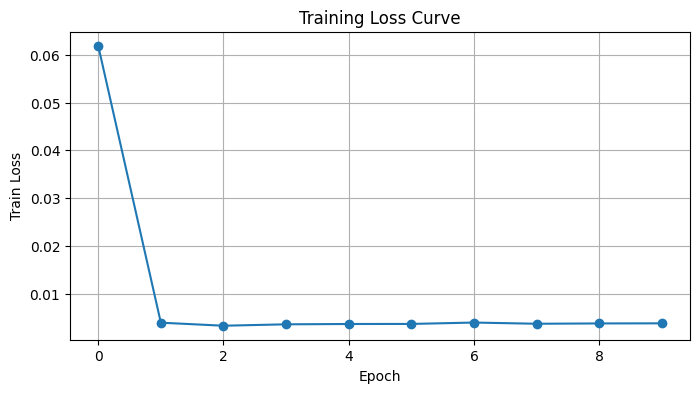

In [8]:
plot_loss_curve(train_losses)

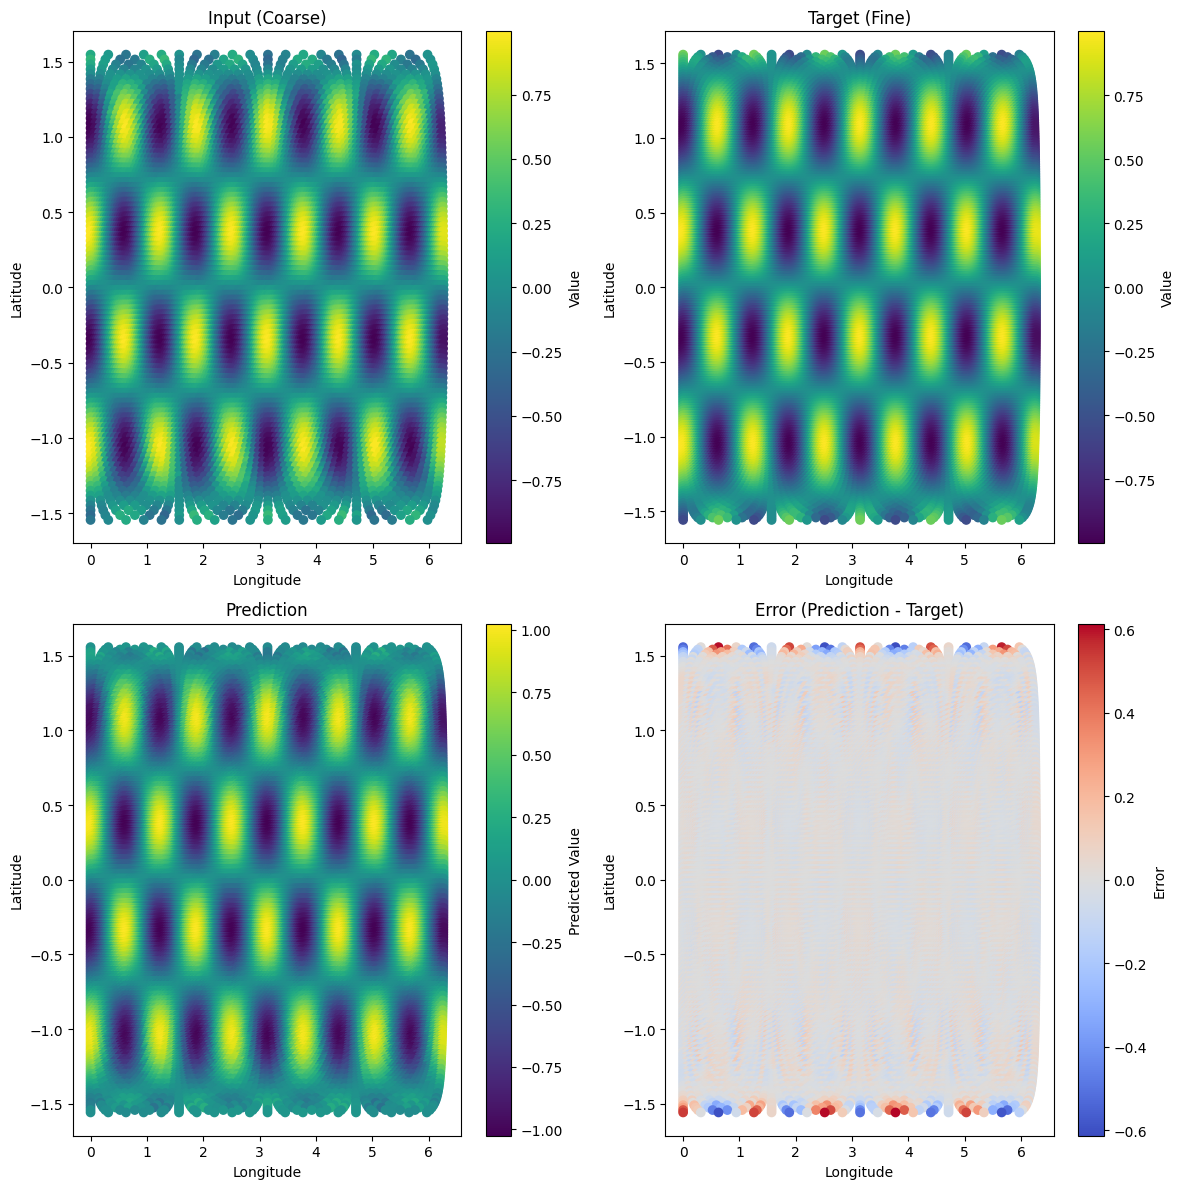

In [9]:
plot_sample(model, dataset[0])

## 6. Extra I

- Implement attentional convolution
- Increase the capacity of the projection layer. Add `LayerNorm` and `ReLU` to the projection layer. Include `mlp_hidden_ration` argument to increase the hidden dimension of the projection MLP.

Before computing attention, the node features are first normalized using `LayerNorm` to stabilize training and improve convergence. Layer normalization helps ensure that the input distributions to the attention mechanism remain consistent, which is especially important when stacking multiple layers or working with varying graph structures. After normalization, the source and target node features are projected into separate query, key, and value spaces using linear layers. These projections form the basis for computing attention scores and aggregating information from neighboring nodes.
![Graph Attention Procesing](assets/graphattention_process.png)

The message creation in attentional convolution involves three main steps:

1. **Projection**:  
    - Source node features are projected into key and value vectors:  

        $ \quad \quad \mathbf{k}_j = W_k \mathbf{x}_j $  
        $ \quad \quad \mathbf{v}_j = W_v \mathbf{x}_j $
    - Target node features are projected into query vectors:  
        $ \quad \quad \mathbf{q}_i = W_q \mathbf{x}_i $

2. **Attention Score Computation**:  
    - For each edge from source node $ j $ to target node $ i $, compute the attention coefficient using the scaled dot-product:  
        $ \quad \quad \alpha_{ij} = \frac{(\mathbf{q}_i \cdot \mathbf{k}_j)}{\sqrt{d}} $

    where $ d $ is the dimensionality of the key/query vectors, `hidden_dim`.

3. **Softmax Normalization and Message Aggregation**:  
    - Normalize the attention coefficients across all neighbors of node $ i $ using softmax:  
      $ \quad \quad a_{ij} = \mathrm{softmax}_j(\alpha_{ij}) $
    - The message from node $ j $ to node $ i $ is the value vector weighted by the normalized attention:  
      $ \quad \quad \mathbf{m}_{ij} = a_{ij} \mathbf{v}_j $
    - The aggregated message at node $ i $ is the sum over all incoming messages:  
      $ \quad \quad \mathbf{m}_i = \sum_{j \in \mathcal{N}(i)} \mathbf{m}_{ij} $

This attentional mechanism allows each node to selectively focus on its most relevant neighbors during message passing.

![Graph Attention Message](assets/graphattention_message.png)

In [ ]:
class GraphTransformer(MessagePassing):
    def __init__(
        self,
        in_channels_src: int,
        in_channels_dst: int,
        hidden_dim: int,
        out_channels: int,
        edge_attr_dim: int = 0,
        mlp_hidden_ratio: int = 4,
        pre_lnorm: bool = False,
    ):
        super().__init__(aggr='add')
        self.hidden_dim = hidden_dim
        self.mlp_hidden_ratio = mlp_hidden_ratio
        self.pre_lnorm = pre_lnorm

        # Define layers
        self.layer_norm_attention_src = nn.LayerNorm(normalized_shape=???)
        self.layer_norm_attention_dst = nn.LayerNorm(normalized_shape=???)

        self.lin_key = nn.Linear(in_channels_src, self.hidden_dim)
        self.lin_query = nn.Linear(in_channels_dst, self.hidden_dim)
        self.lin_value = nn.Linear(???, self.hidden_dim)

        self.lin_dst = nn.Linear(in_channels_dst, self.hidden_dim)
        self.lin_edge = nn.Linear(edge_attr_dim, self.hidden_dim)

        # self.projection = nn.Linear(self.hidden_dim, out_channels)
        self.projection = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.hidden_dim),
            nn.Linear(self.hidden_dim, self.mlp_hidden_ratio * self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_hidden_ratio * self.hidden_dim, out_channels),
        )

    def forward(self, x_src, x_dst, edge_index, edge_attr):        
        query, key, value, edge_attr = self.get_qkve(x_src, x_dst, edge_attr)
        # query: [num_dst_nodes, hidden_dim]
        # key: [num_src_nodes, hidden_dim]
        # value: [num_src_nodes, hidden_dim]

        out = self.propagate(
            edge_index=edge_index.to(torch.int64).to(x_src.device),
            x=(x_src, x_dst),
            size=(x_src.size(0), x_dst.size(0)),
            edge_attr=edge_attr,
            query=query,
            key=key,
            value=value,
        )
        # out: [num_dst_nodes, hidden_dim]

        out = self.projection(out)
        # out: [num_dst_nodes, out_channels]

        return out

    def get_qkve(self, x_src, x_dst, edge_attr):
        if self.pre_lnorm:
            x_src = self.layer_norm_attention_src(x_src)
            x_dst = self.layer_norm_attention_dst(x_dst)

        query = self.lin_query(x_dst)
        key = self.lin_key(x_src)
        value = self.lin_value(x_src)
    
        if edge_attr is not None:
            edge_attr = self.lin_edge(edge_attr)

        return query, key, value, edge_attr

    def message(
        self,
        query_i: torch.Tensor,
        key_j: torch.Tensor,
        value_j: torch.Tensor,
        edge_attr: torch.Tensor,
        index: torch.Tensor,
        ptr: torch.Tensor,
        size_i: int,
    ) -> torch.Tensor:
        # query_i, key_j, value_j: [num_edges, hidden_dim]

        if edge_attr is not None:
            key_j = key_j + edge_attr

        # Compute attention coefficients
        alpha = (query_i * key_j).sum(dim=-1) / self.hidden_dim ** 0.5
        alpha = softmax(alpha, index, ptr, size_i)
        # alpha: [num_edges]

        if edge_attr is not None:
            value_j = value_j + self.lin_edge(edge_attr)

        out = value_j# * alpha.view(-1, 1)
        # out: [num_edges, hidden_dim]

        return out

    def update(self, aggr_out, x: tuple):
        # x: tuple (x_src, x_dst)

        x_dst = self.lin_dst(x[1])
        # x_dst: [num_dst_nodes, num_heads x hidden_dim]

        return aggr_out + x_dst


# DEBUG: You can use this code to debug the forward pass
gnn = GraphTransformer(
    in_channels_src=2, 
    in_channels_dst=2,
    hidden_dim=16,
    out_channels=6,
    edge_attr_dim=1,
    mlp_hidden_ratio=4,
)
output = gnn(
    x_src=graph['input'].x, 
    x_dst=graph['target'].x,
    edge_index=graph[('input', 'to', 'target')].edge_index.to(torch.int64),
    edge_attr=None
)
print(output.shape)  # Should be [num_target_nodes, out_channels]

torch.Size([40320, 6])


In [11]:
gnn = GraphTransformer(
    in_channels_src=dataset.num_variables, 
    in_channels_dst=2,
    hidden_dim=HIDDEN_DIM,
    out_channels=dataset.num_variables,
    edge_attr_dim=0,
)
model, train_losses = train(gnn, dataset, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

/etc/ecmwf/nfs/dh2_home_a/ecm1924/venvs/aifs-env-py311/lib/python3.11/site-packages/torch/nn/init.py:453: UserWarning:

Initializing zero-element tensors is a no-op



Epoch 1, Loss: 0.0164
Epoch 2, Loss: 0.0038
Epoch 3, Loss: 0.0046
Epoch 4, Loss: 0.0039
Epoch 5, Loss: 0.0042
Epoch 6, Loss: 0.0041
Epoch 7, Loss: 0.0040
Epoch 8, Loss: 0.0040
Epoch 9, Loss: 0.0041
Epoch 10, Loss: 0.0037


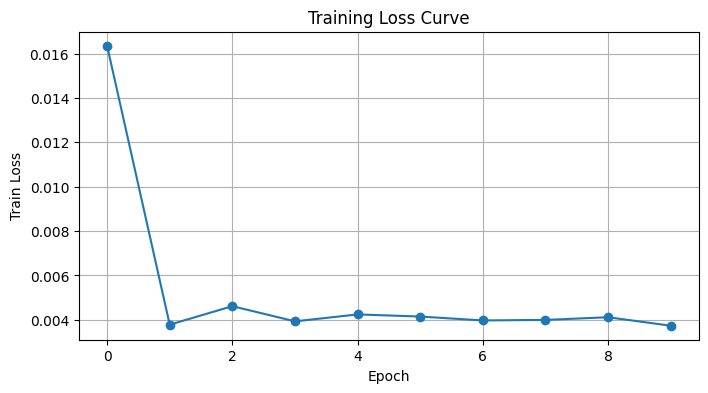

In [12]:
plot_loss_curve(train_losses)

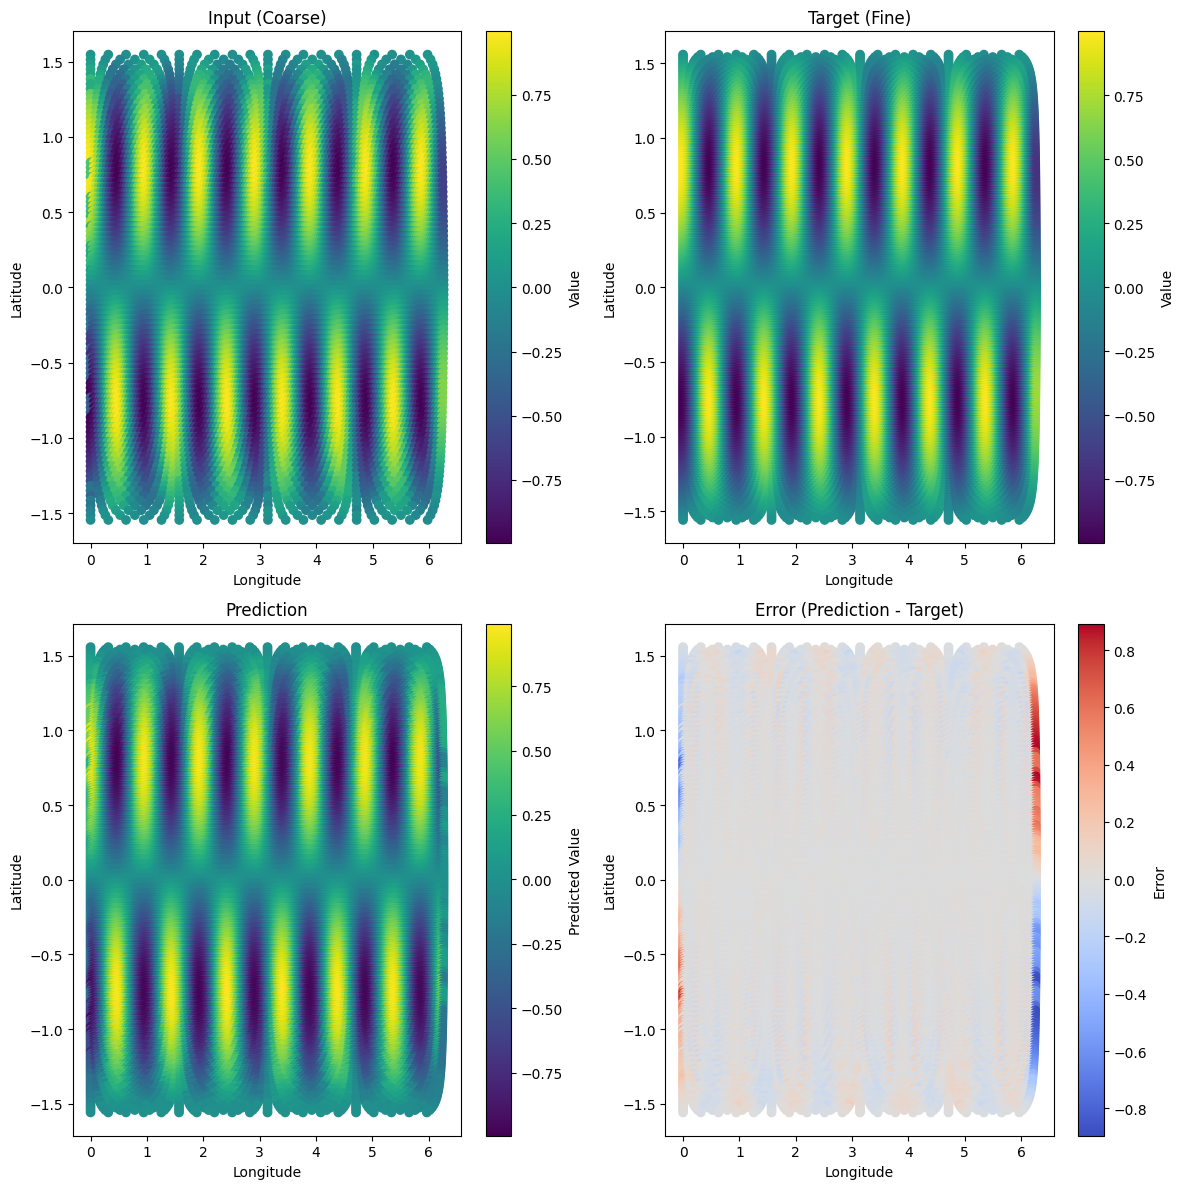

In [13]:
plot_sample(model, dataset[0])

## Extra II

In this final exercise, you'll extend the attentional convolution to support multi-head attention and optional query/key normalization. Multi-head attention enables the model to capture diverse patterns by attending to information from multiple representation subspaces. The `qk_norm` option applies normalization to the query and key vectors before computing attention scores, which can improve stability and expressiveness.

Your task:
- Implement a `MultiHeadGraphTransformer` layer that supports multiple attention heads.
- Add a `qk_norm` argument to optionally normalize query and key vectors.
- Verify your implementation by running the provided code and inspecting the output shapes and training behavior.

In [14]:
class MultiHeadGraphTransformer(MessagePassing):
    def __init__(
        self,
        in_channels_src: int,
        in_channels_dst: int,
        hidden_dim: int,
        out_channels: int,
        num_heads: int = 1,
        edge_attr_dim: int = 0,
        pre_lnorm: bool = False,
        qk_norm: bool = False,
        mlp_hidden_ratio: int = 4,
    ):
        super().__init__(aggr='add')
        self.hidden_dim = hidden_dim
        self.mlp_hidden_ratio = mlp_hidden_ratio
        self.pre_lnorm = pre_lnorm
        self.num_heads = num_heads
        self.qk_norm = qk_norm

        # Define layers
        self.layer_norm_attention_src = nn.LayerNorm(normalized_shape=in_channels_src)
        self.layer_norm_attention_dst = nn.LayerNorm(normalized_shape=in_channels_dst)

        self.lin_key = nn.Linear(in_channels_src, self.num_heads * self.hidden_dim)
        self.lin_query = nn.Linear(in_channels_dst, self.num_heads * self.hidden_dim)
        self.lin_value = nn.Linear(in_channels_src, self.num_heads * self.hidden_dim)

        self.lin_dst = nn.Linear(in_channels_dst, self.num_heads * self.hidden_dim)
        self.lin_edge = nn.Linear(edge_attr_dim, self.num_heads * self.hidden_dim)

        if self.qk_norm:
            self.q_norm = nn.LayerNorm(self.hidden_dim)
            self.k_norm = nn.LayerNorm(self.hidden_dim)

        self.projection = nn.Sequential(
            nn.LayerNorm(normalized_shape=self.num_heads * self.hidden_dim),
            nn.Linear(self.num_heads * self.hidden_dim, self.mlp_hidden_ratio * self.hidden_dim),
            nn.ReLU(),
            nn.Linear(self.mlp_hidden_ratio * self.hidden_dim, out_channels),
        )

    def forward(self, x_src, x_dst, edge_index, edge_attr):        
        query, key, value, edge_attr = self.get_qkve(x_src, x_dst, edge_attr)
        # query: [num_dst_nodes, num_heads x hidden_dim]
        # key: [num_src_nodes, num_heads x hidden_dim]
        # value: [num_src_nodes, num_heads x hidden_dim]
    
        out = self.propagate(
            edge_index=edge_index.to(torch.int64).to(x_src.device),
            x=(x_src, x_dst),
            size=(x_src.size(0), x_dst.size(0)),
            edge_attr=edge_attr,
            query=query,
            key=key,
            value=value,
        )
        # out: [num_dst_nodes, num_heads x hidden_dim]

        out = self.projection(out)
        # out: [num_dst_nodes, out_channels]

        return out

    def get_qkve(self, x_src, x_dst, edge_attr):
        if self.pre_lnorm:
            x_src = self.layer_norm_attention_src(x_src)
            x_dst = self.layer_norm_attention_dst(x_dst)

        query = self.lin_query(x_dst)
        key = self.lin_key(x_src)
        value = self.lin_value(x_src)

        if self.qk_norm:
            query = self.q_norm(query)
            key = self.k_norm(key)

        if edge_attr is not None:
            edge_attr = self.lin_edge(edge_attr)

        return query, key, value, edge_attr

    def message(
        self,
        query_i: torch.Tensor,
        key_j: torch.Tensor,
        value_j: torch.Tensor,
        edge_attr: torch.Tensor,
        index: torch.Tensor,
        ptr: torch.Tensor,
        size_i: int,
    ) -> torch.Tensor:
        query_i = einops.rearrange(query_i, "edges (heads vars) -> edges heads vars", heads=self.num_heads)
        key_j = einops.rearrange(key_j, "edges (heads vars) -> edges heads vars", heads=self.num_heads)
        value_j = einops.rearrange(value_j, "edges (heads vars) -> edges heads vars", heads=self.num_heads)
        # query_i, key_j, value_j: [num_edges, num_heads, hidden_dim]

        if edge_attr is not None:
            edge_attr = einops.rearrange(edge_attr, "edges (heads vars) -> edges heads vars", heads=self.num_heads)
            key_j = key_j + edge_attr

        # Compute attention coefficients
        alpha = (query_i * key_j).sum(dim=-1) / self.hidden_dim ** 0.5
        alpha = softmax(alpha, index, ptr, size_i)
        # alpha: [num_edges, num_heads]

        if edge_attr is not None:
            value_j = value_j + self.lin_edge(edge_attr)

        out = value_j * alpha.view(-1, self.num_heads, 1)
        # out: [num_edges, num_heads, hidden_dim]

        out = einops.rearrange(out, "edges heads vars -> edges (heads vars)")
        # out: [num_edges, num_heads x hidden_dim]
        
        return out

    def update(self, aggr_out, x: tuple):
        # x: tuple (x_src, x_dst)

        x_dst = self.lin_dst(x[1])
        # x_dst: [num_dst_nodes, num_heads x hidden_dim]

        return aggr_out + x_dst


# DEBUG: You can use this code to debug the forward pass
gnn = MultiHeadGraphTransformer(
    in_channels_src=2, 
    in_channels_dst=2,
    hidden_dim=16,
    out_channels=6,
    edge_attr_dim=1,
    num_heads=3,
)
output = gnn(
    x_src=graph['input'].x, 
    x_dst=graph['target'].x,
    edge_index=graph[('input', 'to', 'target')].edge_index.to(torch.int64),
    edge_attr=None
)
print(output.shape)  # Should be [num_target_nodes, out_channels]

torch.Size([40320, 6])


In [15]:
gnn = MultiHeadGraphTransformer(
    in_channels_src=dataset.num_variables, 
    in_channels_dst=2,
    hidden_dim=HIDDEN_DIM,
    out_channels=dataset.num_variables,
    edge_attr_dim=0,
)
model, train_losses = train(gnn, dataset, epochs=NUM_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

Epoch 1, Loss: 0.0859
Epoch 2, Loss: 0.0090
Epoch 3, Loss: 0.0051
Epoch 4, Loss: 0.0046
Epoch 5, Loss: 0.0039
Epoch 6, Loss: 0.0044
Epoch 7, Loss: 0.0041
Epoch 8, Loss: 0.0043
Epoch 9, Loss: 0.0039
Epoch 10, Loss: 0.0040


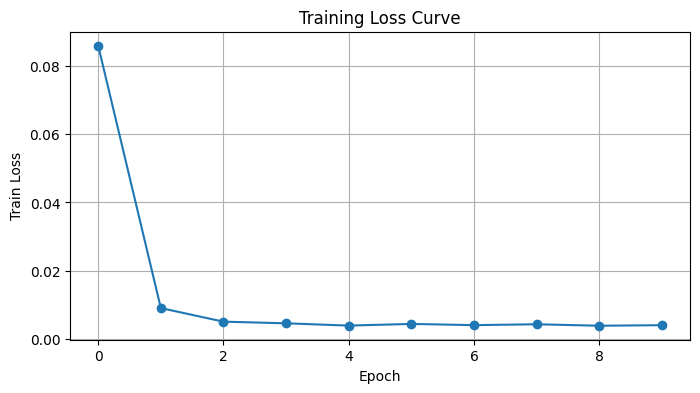

In [16]:
plot_loss_curve(train_losses)

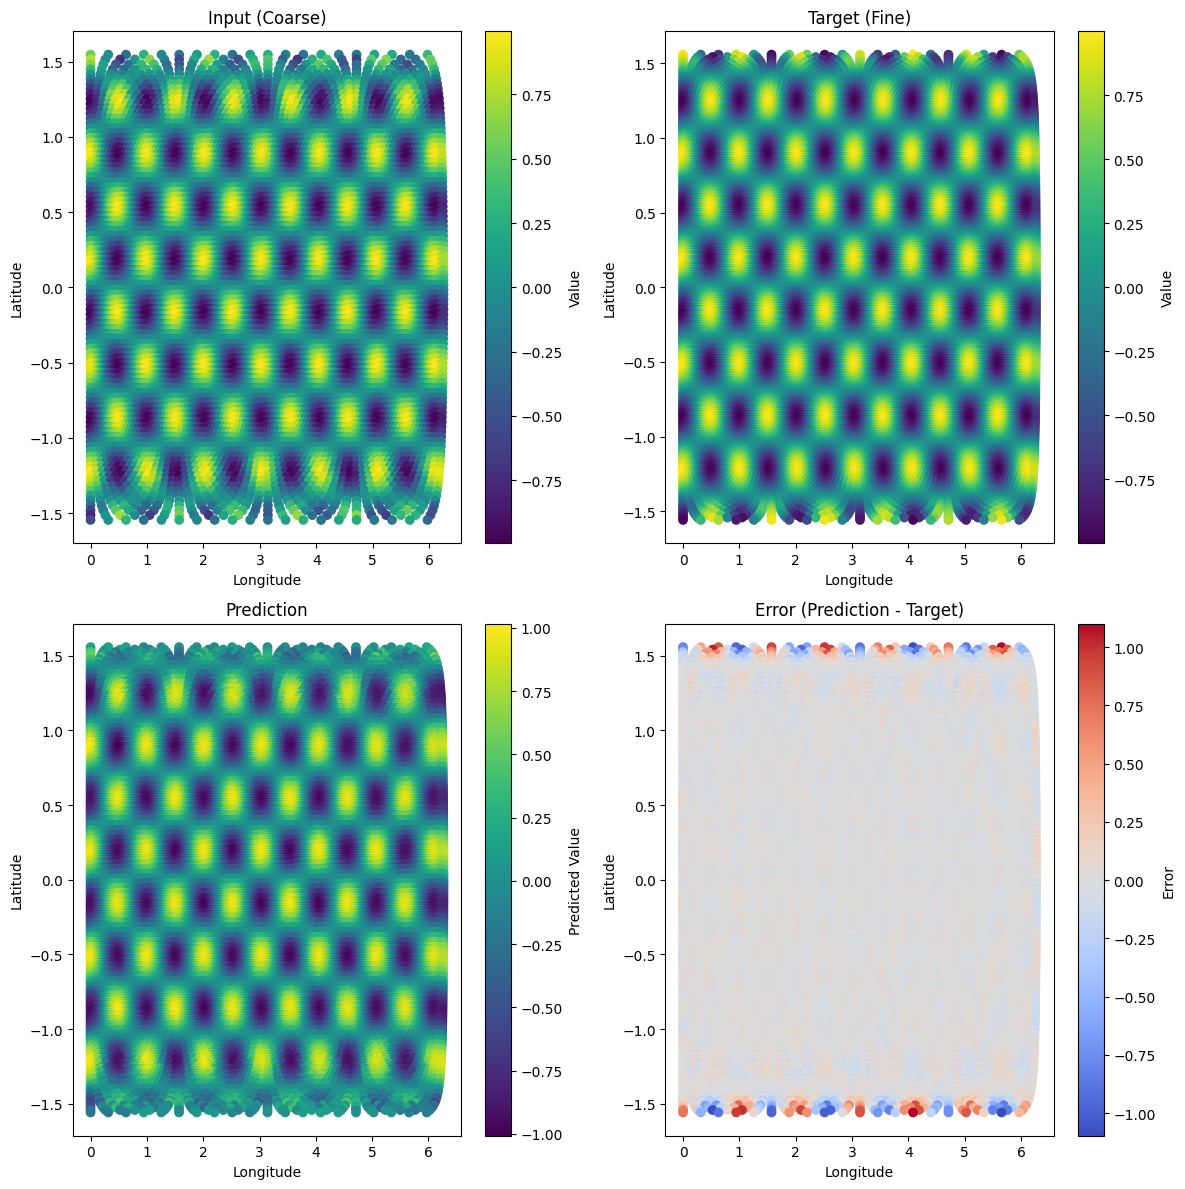

In [17]:
plot_sample(model, dataset[0])